In [1]:
import os
import cv2
import pytesseract
import math

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Change the path if tesseract.exe is found in a different path in your computer
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'

In [3]:
# Change the path to where your plate images are stored.
img_dir = 'C:\\tmp\\license_plates'

In [4]:
plate_filenames = os.listdir(img_dir)

path_to_plates = []
images = []

# All file paths are appended to path_to_plates list
# All images are appended to images list
for f in plate_filenames:
    path = os.path.join(img_dir,f)
    path_to_plates.append(path)
    
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    images.append(img)

In [5]:
def clean_plate_no(plate):
    '''
    Helper function to remove unexpected chars from the recognized plate no
    '''
    plate_chars = [x for x in 'ABCDEFGHIJKLMNOPRSTUVYZ0123456789']
    return ''.join([x for x in plate if x in plate_chars])

In [6]:
def read_plate(img):
    '''
    Gets the image, converts to gray scale,
    blurs, detects edges, finds contours with 4 sides (possibly the plate),
    applies OCR, and removes unexpected chars.
    
    Returns a tuple (found, plate)
    found(boolean) : whether a plate contour is found or not
    plate(str)     : extracted text if found is True, error msg if found is False
     '''
    
    # Convert to b&w
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Blur image before edge detection
    blurred_image = cv2.blur(gray_img,(5,5))
        
    # Detect edges
    edged_img = cv2.Canny(gray_img, 50, 200)
    
    # Find contours
    contours, hierarchy = cv2.findContours(edged_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
       
    # Sort the contours by area and grab only the largest 10
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
    
    plate_contour = None
    
    # look for a contour with 4 edges (possible the plate)
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            plate_contour = approx
            break
        
    if plate_contour is None:
        return (False, 'Contour not detected!')
    else:
        
        # Mask all but the plate contour
        mask = np.zeros(gray_img.shape,np.uint8)
        masked_img = cv2.drawContours(mask,[plate_contour],0,255,-1,)
        masked_img = cv2.bitwise_and(img,img,mask=mask)

        # Crop the plate
        (x, y) = np.where(mask == 255)
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        cropped_plate = gray_img[topx:bottomx+1, topy:bottomy+1]

        # apply OCR 
        plate_no = pytesseract.image_to_string(cropped_plate, config='--psm 6')

        # remove unexpected chars from the OCR and return the value
        return (True, clean_plate_no(plate_no))
    

In [7]:
extracted_plates = []
for img in images:
    extracted_plates.append(read_plate(img))

In [8]:
print('Filename \t Contour\t Result')
for i,(found, plate_no) in enumerate(extracted_plates):
    print(plate_filenames[i],'\t',found,'\t\t',plate_no)

Filename 	 Contour	 Result
03HP408.jpg 	 True 		 03HP408
06AY6651.jpeg 	 False 		 Contour not detected!
06CNU56.png 	 False 		 Contour not detected!
06GKN62.jpg 	 True 		 06GKN62
06KB848.jpeg 	 True 		 O6KB8L8
06LRN01.jpg 	 False 		 Contour not detected!
09BT449.jpg 	 False 		 Contour not detected!
19AAB001.jpg 	 True 		 19AAB001
33BJJ09.jpg 	 True 		 33BJJ09
34DUA34.jpg 	 True 		 34DUA34
34SG1957.png 	 True 		 34SG1957
34VG743.jpg 	 False 		 Contour not detected!
34ZB3636.jpg 	 True 		 34ZB3636
35AD4597.jpg 	 False 		 Contour not detected!
35AD7227.jpg 	 True 		 35AD7227
35AP7605.jpg 	 False 		 Contour not detected!
35GA4434.jpg 	 True 		 35GAL434
38VU055.jpg 	 True 		 38VU055
42FNG29.jpg 	 True 		 42FNG29
44AB044.jpg 	 False 		 Contour not detected!


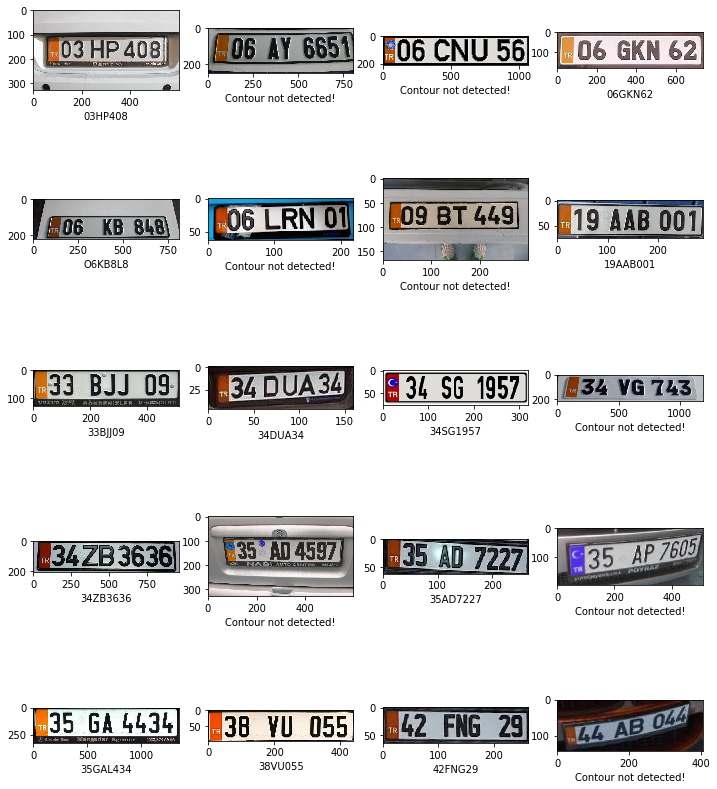

In [9]:
ncols = 4
nrows = math.ceil(len(images)/ncols)

plt.figure(figsize=(ncols*3,nrows*3))
#plt.grid(False)

for i,img in enumerate(images):
    plt.subplot(nrows,ncols,i+1, xlabel=extracted_plates[i][1])
    plt.imshow(img)
    
